In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora
import ast
import re

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
uk_pol_tokens = pd.read_csv('uk_pol_tokens.csv', converters={4:ast.literal_eval})

In [3]:
uk_pol_tokens.head()

,speaker,party,date,subject,tokenised
0,Mark Isherwood,Conservative,2006-01-10,Fuel Poverty,"[chartered, institute, housing, states, reason..."
1,Chuka Umunna,Labour,2011-12-02,Universities UK,"[thank, kind, welcome, hugely, grateful, invit..."
2,Chuka Umunna,Labour,2012-01-12,High Pay Commission,"[thank, introduction, hosting, event, thank, h..."
3,Chuka Umunna,Labour,2012-06-26,Hub Westminster,"[thank, introduction, thank, inviting, speak, ..."
4,Chuka Umunna,Labour,2012-05-28,UCATT Conference,"[conference, thank, much, inviting, speak, tod..."


In [3]:
# create a list of tokenised speeches
doc_clean = [text for text in uk_pol_tokens.tokenised]

In [4]:
# map the words to an index
dictionary = corpora.Dictionary(doc_clean)

In [5]:
# vectorise
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

### Don't run the below cell again or we will lose the nice topics

Edit: should have used a random state to make it repeatable (using 1 got similar results to below). Remember this if re-running.

In [24]:
Lda = gensim.models.ldamodel.LdaModel

# generate the topics. this takes a while, and I had to re-run a few times to get topics that
# make sense. I picked 6 topics because it gave me a good range but that might vary for
# different data sets
ldamodel = Lda(doc_term_matrix, num_topics=6, id2word = dictionary, passes=50)

# ldamodel.print_topics(num_topics=6, num_words=8)

topic_ident = re.compile(r'[a-z]+')

# just wrote this loop to separate out the words from the weightings and print them nicely
for topic in ldamodel.print_topics(num_topics=6, num_words=8):
    print(' '.join(re.findall(topic_ident,topic[1])))

schools education people children school young work want
nhs health services care patients public service new
people government country work one need make want
police crime people public women also work policing
eu uk world would us europe people trade
new uk government also world business year investment


In [ ]:
new uk government also world business year investment

In [84]:
# this is what the topics look like with the weightings
ldamodel.print_topics(num_topics=6, num_words=8)

[(0,
  '0.014*"schools" + 0.013*"education" + 0.011*"people" + 0.011*"children" + 0.010*"school" + 0.008*"young" + 0.007*"work" + 0.006*"want"'),
 (1,
  '0.028*"nhs" + 0.021*"health" + 0.018*"services" + 0.017*"care" + 0.012*"patients" + 0.011*"public" + 0.009*"service" + 0.008*"new"'),
 (2,
  '0.020*"people" + 0.012*"government" + 0.009*"country" + 0.008*"work" + 0.007*"one" + 0.007*"need" + 0.006*"make" + 0.006*"want"'),
 (3,
  '0.013*"police" + 0.010*"crime" + 0.006*"people" + 0.005*"public" + 0.005*"women" + 0.004*"also" + 0.004*"work" + 0.004*"policing"'),
 (4,
  '0.009*"eu" + 0.009*"uk" + 0.008*"world" + 0.008*"would" + 0.007*"us" + 0.006*"europe" + 0.006*"people" + 0.006*"trade"'),
 (5,
  '0.011*"new" + 0.009*"uk" + 0.007*"government" + 0.006*"also" + 0.006*"world" + 0.005*"business" + 0.005*"year" + 0.005*"investment"')]

In [83]:
# this is how you get the predicted groups from the model for each text
doc = uk_pol_tokens.iloc[0,4]
bowvector = dictionary.doc2bow(doc)
sorted(ldamodel[bowvector], key=lambda tup: -1*tup[1])

[(2, 0.5386748),
 (5, 0.23573303),
 (4, 0.11899701),
 (3, 0.062078472),
 (1, 0.044133436)]

In [86]:
topics = ldamodel.print_topics(num_topics=6, num_words=8)
topic_ident = re.compile(r'[a-z]+')

def get_topic(text):
    '''function to return the cleaned topic words list for a text'''
    bowvector = dictionary.doc2bow(text)
    topic_no = sorted(ldamodel[bowvector], key=lambda tup: -1*tup[1])[0][0]
    topic_list_dirty = ldamodel.print_topics(num_topics=6, num_words=8)[topic_no][1].split('+')
    topic_list_clean = []
    for topic in topic_list_dirty:
        topic_list_clean.append(' '.join(re.findall(topic_ident,topic)))
    return ' '.join(topic_list_clean)

In [26]:
uk_pol_tokens['topic'] = uk_pol_tokens.tokenised.map(lambda x: get_topic(x))

In [27]:
uk_pol_tokens.topic.value_counts()

eu uk world would us europe people trade                    618
new uk government also world business year investment       564
people government country work one need make want           549
police crime people public women also work policing         282
schools education people children school young work want    269
nhs health services care patients public service new        111
Name: topic, dtype: int64

In [28]:
# uk_pol_tokens.to_csv('uk_pol_topics.csv', index=False)

In [6]:
uk_pol_topics = pd.read_csv('uk_pol_topics.csv')

In [7]:
# I manually assigned topic titles based on what the topic words looked like.
topic_dict = {'eu uk world would us europe people trade':'global',
              'new uk government also world business year investment':'business',
              'people government country work one need make want':'uk society',
              'police crime people public women also work policing':'crime',
              'schools education people children school young work want':'education',
              'nhs health services care patients public service new':'health'}

In [8]:
uk_pol_topics['topic_title'] = uk_pol_topics.topic.map(lambda x: topic_dict[x])

In [9]:
uk_pol_topics.topic_title.value_counts()

global        618
business      564
uk society    549
crime         282
education     269
health        111
Name: topic_title, dtype: int64

In [10]:
uk_pol_topics.to_csv('uk_pol_topics.csv', index=False)

In [11]:
uk_pol_topics.head()

,speaker,party,date,subject,tokenised,topic,topic_title
0,Mark Isherwood,Conservative,2006-01-10,Fuel Poverty,"['chartered', 'institute', 'housing', 'states'...",people government country work one need make want,uk society
1,Chuka Umunna,Labour,2011-12-02,Universities UK,"['thank', 'kind', 'welcome', 'hugely', 'gratef...",schools education people children school young...,education
2,Chuka Umunna,Labour,2012-01-12,High Pay Commission,"['thank', 'introduction', 'hosting', 'event', ...",people government country work one need make want,uk society
3,Chuka Umunna,Labour,2012-06-26,Hub Westminster,"['thank', 'introduction', 'thank', 'inviting',...",people government country work one need make want,uk society
4,Chuka Umunna,Labour,2012-05-28,UCATT Conference,"['conference', 'thank', 'much', 'inviting', 's...",people government country work one need make want,uk society


In [12]:
uk_pol_topics.groupby('party')['topic_title'].count()

party
Conservative    1723
Labour           670
Name: topic_title, dtype: int64

In [13]:
topics_by_party = pd.DataFrame(uk_pol_topics.groupby(['party','topic_title'])['topic_title'].count()/uk_pol_topics.groupby('party')['topic_title'].count()*100)

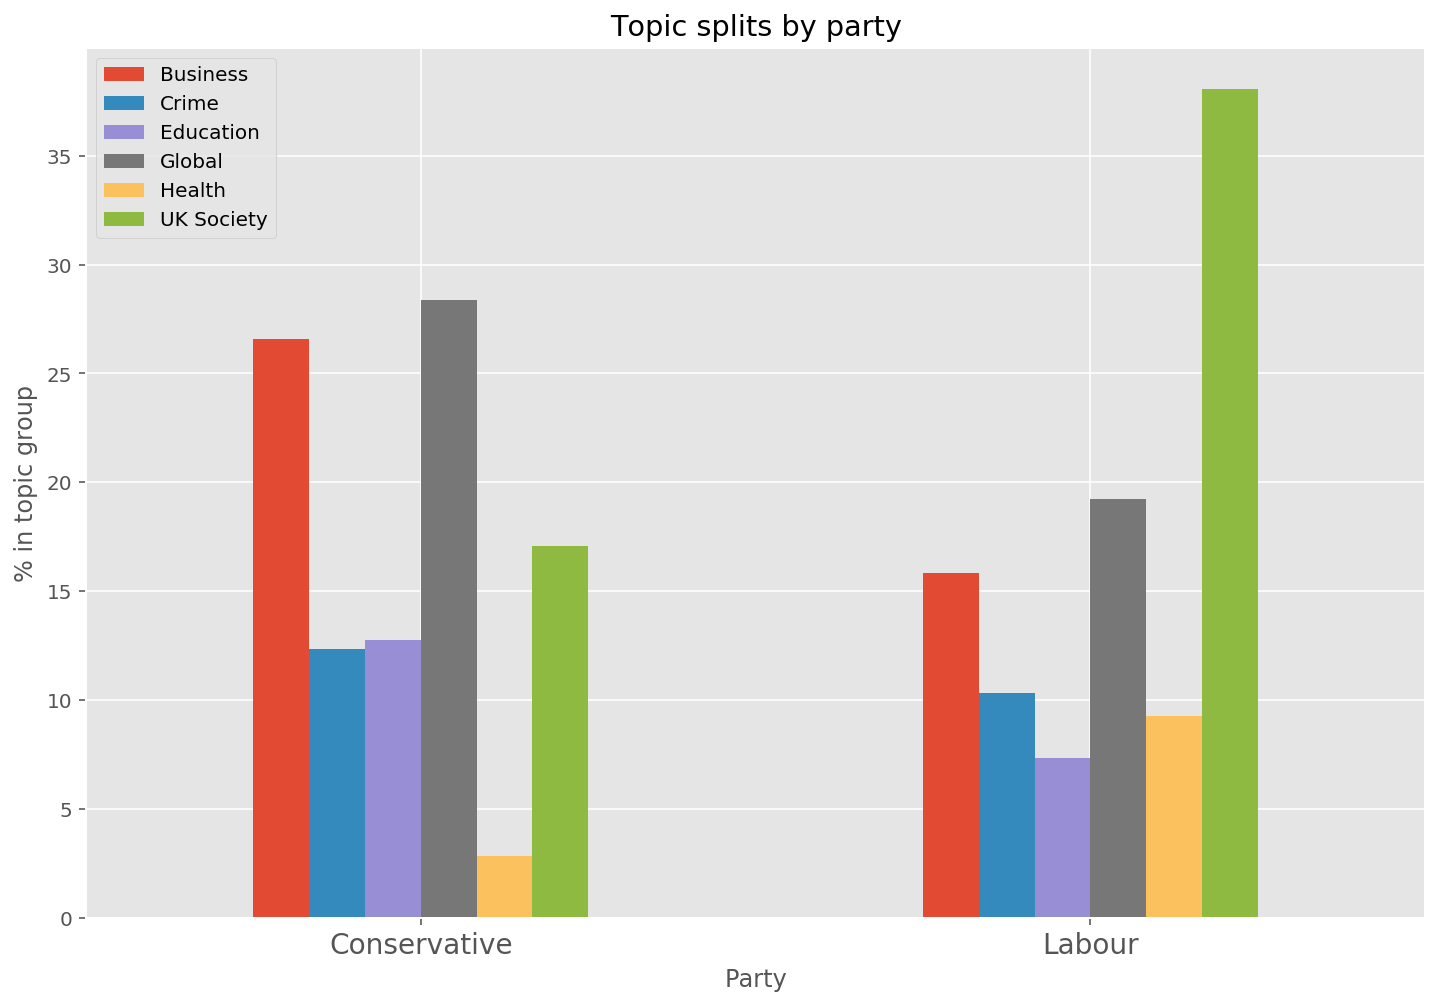

In [20]:
fig, ax = plt.subplots(figsize=(12,8))

topics_by_party.unstack().plot(kind='bar', ax=ax, rot=0)

ax.legend(['Business','Crime','Education','Global','Health','UK Society'])
ax.set_xlabel('Party')
ax.set_ylabel('% in topic group')

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.title('Topic splits by party')
plt.show();

In [79]:
uk_pol_topics.head()

,speaker,party,date,subject,tokenised,topic,topic_title
0,Mark Isherwood,Conservative,2006-01-10,Fuel Poverty,"['chartered', 'institute', 'housing', 'states'...",people government country work one need make want,uk society
1,Chuka Umunna,Labour,2011-12-02,Universities UK,"['thank', 'kind', 'welcome', 'hugely', 'gratef...",schools education people children school young...,education
2,Chuka Umunna,Labour,2012-01-12,High Pay Commission,"['thank', 'introduction', 'hosting', 'event', ...",people government country work one need make want,uk society
3,Chuka Umunna,Labour,2012-06-26,Hub Westminster,"['thank', 'introduction', 'thank', 'inviting',...",people government country work one need make want,uk society
4,Chuka Umunna,Labour,2012-05-28,UCATT Conference,"['conference', 'thank', 'much', 'inviting', 's...",people government country work one need make want,uk society


In [22]:
maiden_topics_by_party = pd.DataFrame(uk_pol_topics[uk_pol_topics.subject=='Maiden Speech'].groupby(['party','topic_title'])['topic_title'].count()/uk_pol_topics[uk_pol_topics.subject=='Maiden Speech'].groupby('party')['topic_title'].count()*100)

In [23]:
maiden_topics_by_party

topic_title
party        topic_title             
Conservative business        3.278689
             crime           3.278689
             education       4.918033
             global         37.704918
             health          1.639344
             uk society     49.180328
Labour       business        5.000000
             crime           5.000000
             education       1.666667
             global         21.666667
             uk society     66.666667

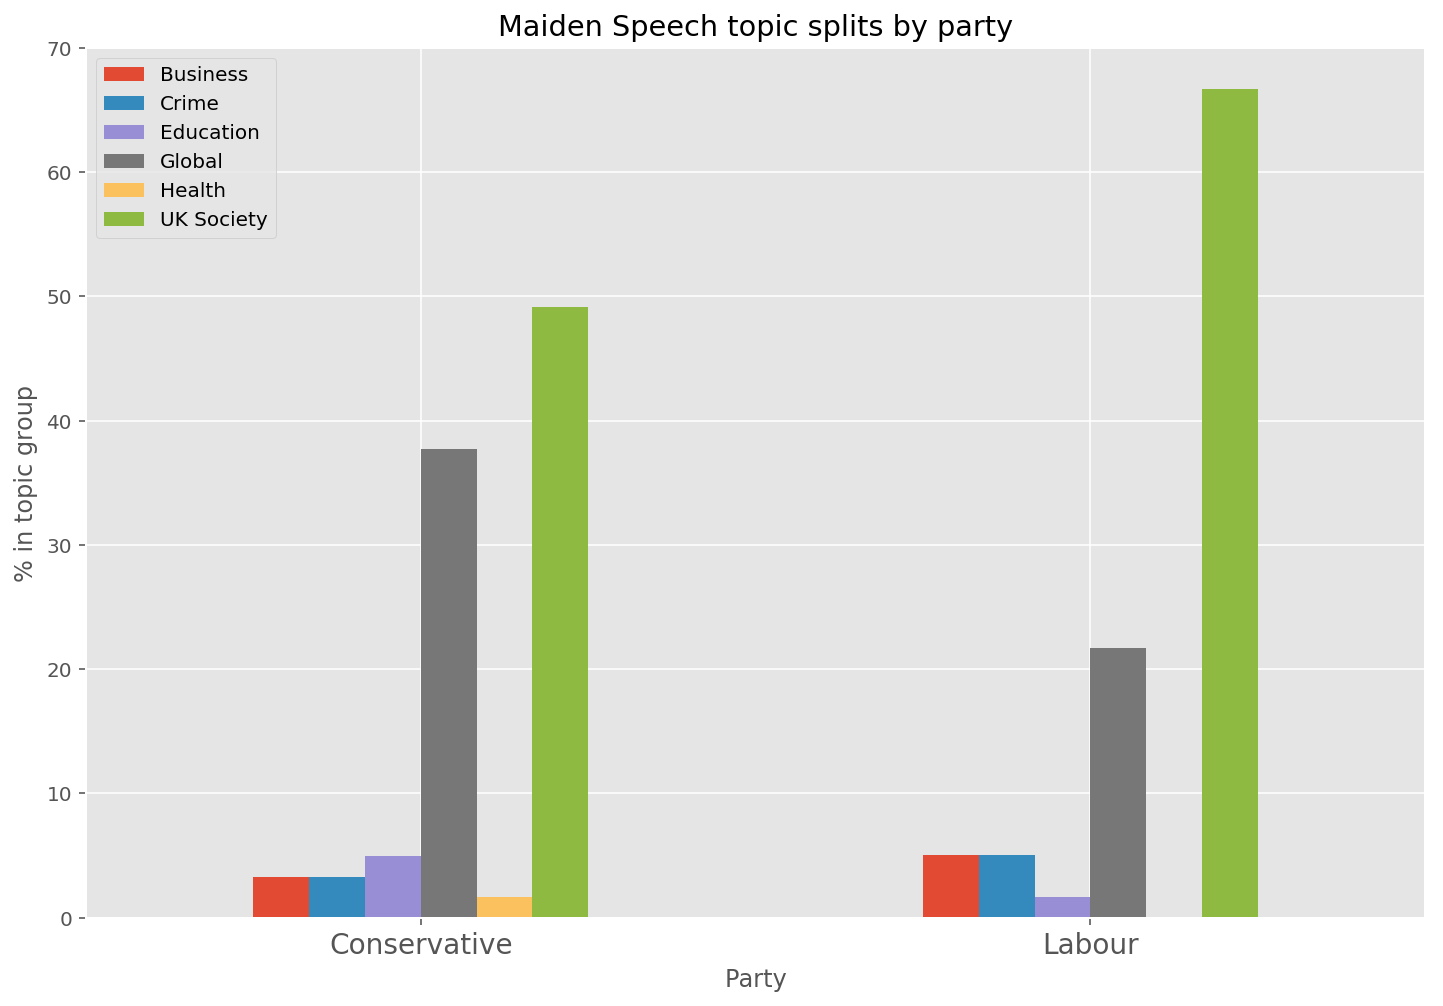

In [41]:
fig, ax = plt.subplots(figsize=(12,8))

maiden_topics_by_party.unstack().plot(kind='bar', ax=ax, rot=0)

ax.legend(['Business','Crime','Education','Global','Health','UK Society'])
ax.set_xlabel('Party')
ax.set_ylabel('% in topic group')

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.title('Maiden Speech topic splits by party')
plt.show();

In [35]:
uk_pol_topics[uk_pol_topics.topic_title=='education'].subject.value_counts()[:10]

Academies                          4
Maiden Speech                      4
Education                          3
Social Mobility                    3
Apprenticeships                    3
Speech at Education World Forum    3
Labour Party Conference            3
School Funding                     2
Welfare Reform                     2
School Improvement                 2
Name: subject, dtype: int64

In [36]:
uk_pol_topics[uk_pol_topics.topic_title=='business'].subject.value_counts()[:10]

Mansion House Speech       7
Climate Change             6
HS2                        6
Maiden Speech              5
Oxford Media Convention    4
Speech at Chatham House    4
Environment                4
CBI Conference             3
Speech at Davos            3
Creative Industries        3
Name: subject, dtype: int64

In [37]:
uk_pol_topics[uk_pol_topics.topic_title=='health'].subject.value_counts()[:10]

King’s Fund                      5
Junior Doctors                   3
Conservative Party Conference    3
Labour Party Conference          2
Junior Doctors Contracts         2
NHS Plan                         1
Foundation Hospitals             1
GP Training                      1
NHS Chairs Conference            1
Primary Care                     1
Name: subject, dtype: int64

In [38]:
uk_pol_topics[uk_pol_topics.topic_title=='global'].subject.value_counts()[:10]

Maiden Speech                       36
Syrian Air Strikes                  15
Brexit                              13
Commons on Queen’s 90th Birthday     7
Labour Party Conference              7
European Union                       5
Withdrawal from EU                   5
Conservative Party Conference        5
Iraq                                 4
Syria                                4
Name: subject, dtype: int64

In [39]:
uk_pol_topics[uk_pol_topics.topic_title=='uk society'].subject.value_counts()[:10]

Maiden Speech                        70
Labour Party Conference              44
Conservative Party Conference        27
Speech at Labour Party Conference    12
TUC Conference                       11
Economy                               7
Budget Speech                         6
Conservative Spring Conference        5
Housing                               5
Welfare Reform                        4
Name: subject, dtype: int64

In [40]:
uk_pol_topics[uk_pol_topics.topic_title=='crime'].subject.value_counts()[:10]

Jo Cox                                    6
Labour Party Conference                   5
Maiden Speech                             5
Infected Blood Inquiry                    4
Modern Slavery                            3
Syria                                     3
Westminster Terror Attack                 3
Speech at Police Federation Conference    3
Police Federation Conference              3
Sky/Fox Merger                            2
Name: subject, dtype: int64

In [94]:
uk_pol_topics[uk_pol_topics.subject.str.contains('Conference')].topic_title.value_counts()

uk society    164
business       78
global         68
education      44
crime          34
health         27
Name: topic_title, dtype: int64

In [95]:
conf_topics_by_party = pd.DataFrame(uk_pol_topics[uk_pol_topics.subject.str.contains('Conference')].groupby(['party','topic_title'])['topic_title'].count()/uk_pol_topics[uk_pol_topics.subject.str.contains('Conference')].groupby('party')['topic_title'].count()*100)

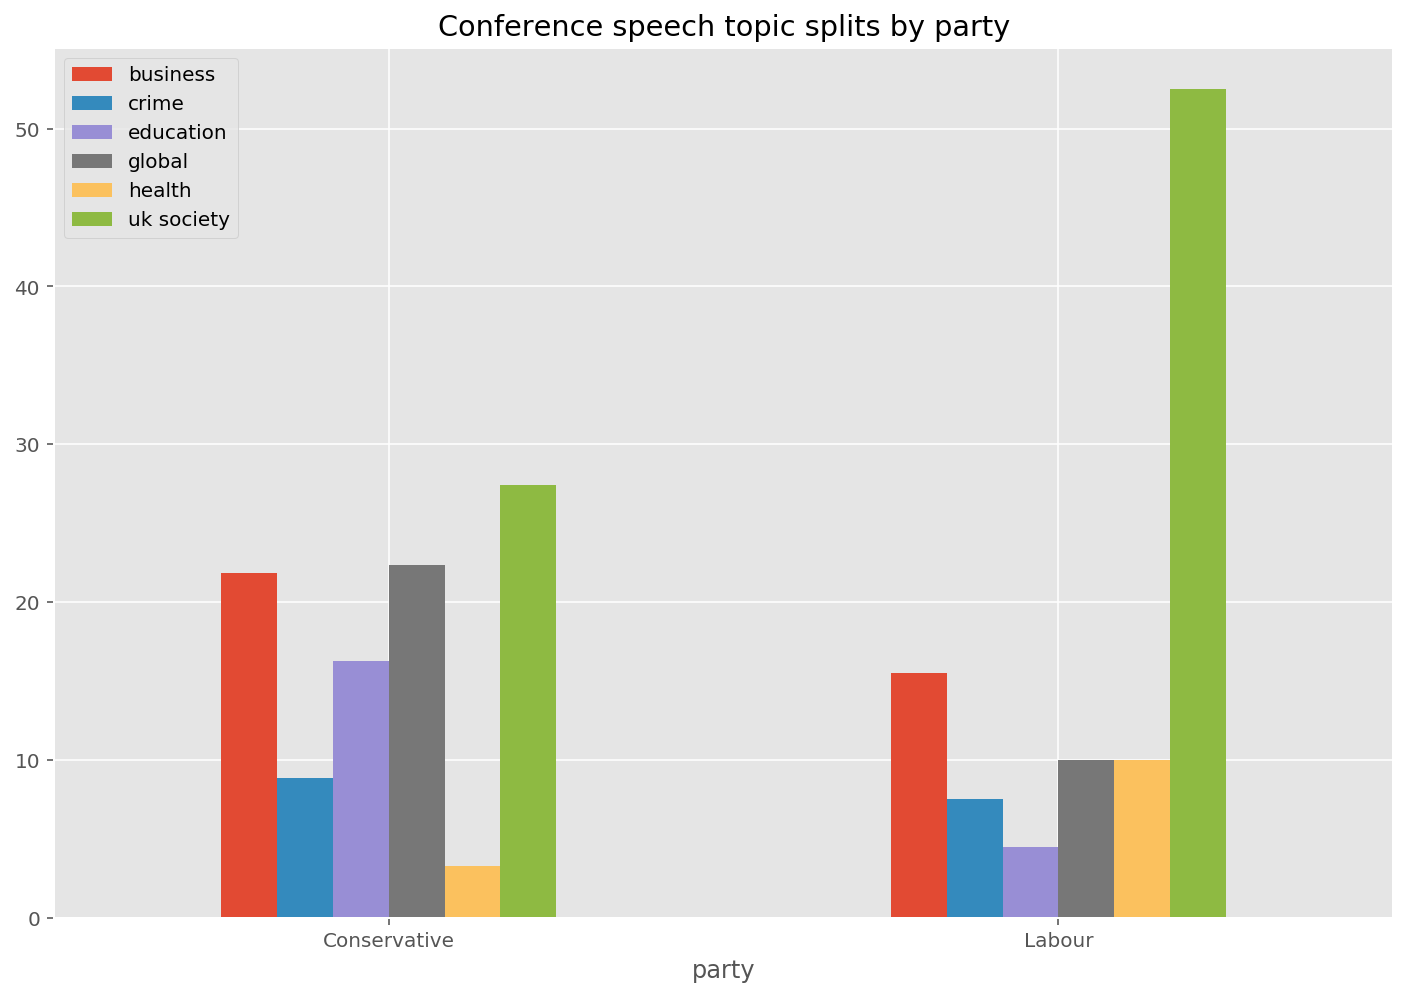

In [96]:
fig, ax = plt.subplots(figsize=(12,8))

conf_topics_by_party.unstack().plot(kind='bar', ax=ax, rot=0)

ax.legend(['business','crime','education','global','health','uk society'])

plt.title('Conference speech topic splits by party')
plt.show();

### Random state test for my own interest:

In [6]:
Lda = gensim.models.ldamodel.LdaModel

In [7]:
# generate the topics. this takes a while, and I had to re-run a few times to get topics that
# make sense. I picked 6 topics because it gave me a good range but that might vary for
# different data sets
ldamodel = Lda(doc_term_matrix, num_topics=6, id2word = dictionary, passes=50, random_state=1)

# ldamodel.print_topics(num_topics=6, num_words=8)

topic_ident = re.compile(r'[a-z]+')

# just wrote this loop to separate out the words from the weightings and print them nicely
for topic in ldamodel.print_topics(num_topics=6, num_words=8):
    print(' '.join(re.findall(topic_ident,topic[1])))

police crime public people work need policing government
people government new country economy need work one
uk eu world security us countries people europe
nhs health services care patients public new service
government would one hon house people right many
people schools education work children school young need
